In [ ]:
!pip install pyyaml h5py

In [5]:
import math
import numpy as np
import re
import os
import cv2

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [6]:
WIDTH = 320
HEIGHT = 180

## Load data

In [7]:
PATH = r"/home/fizzer/cnn_trainer/data/"
labels_raw = os.listdir(PATH)
labels = labels_raw
print(len(labels))


# GOOGLE COLAB
# # You will need to update this path to match the folder in your Google Drive
# PATH = "/content/data/"
# labels_raw = !ls "{PATH}"
# labels_tot = []
# for label in labels_raw:
#     for im in label.split():
#         labels_tot.append(im)
# print(np.size(labels_tot))
# print(labels_raw[-1])
# print(labels_tot)

3375


In [8]:
# Load the images and assign label 0 and 1
# imgset0 = np.array([[np.array(Image.open(f'{PATH}/{file}')), 0]
#                     for file in labels[:]])

imgset0 = []
for label in labels:
    # imgray = cv2.cvtColor(np.array(Image.open(f'{PATH}/{label}')), cv2.COLOR_BGR2GRAY)
    thresh = 200
    im_bw = cv2.threshold(np.array(Image.open(f'{PATH}/{label}')), thresh, 255, cv2.THRESH_BINARY)[1]
    dim = (320, 180)
    im_rs = cv2.resize(im_bw, dim, interpolation = cv2.INTER_AREA)
    if label[-5] == 'R':
        action = -1
    elif label[-5] == 'F':
        action = 0
    else:
        action = 1
    imgset0.append([im_rs, action])

print(np.shape(imgset0))

(3375, 2)


/home/fizzer/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [9]:
all_dataset = imgset0

In [10]:
# Shuffle the dataset
np.random.shuffle(all_dataset)

In [11]:
# Generate X and Y datasets
X_dataset_orig = np.array([data[0] for data in all_dataset[:]], dtype=object)
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

In [26]:
NUMBER_OF_LABELS = 3
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
# Normalize X (images) dataset
X_dataset = X_dataset_orig
for i in range(len(X_dataset_orig)):
    X_dataset[i] = X_dataset[i]/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T
X_dataset_init = X_dataset

In [13]:
VALIDATION_SPLIT = 0.2

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 3375
Training examples: 2700
Test examples: 675
X shape: (3375, 180, 320)
Y shape: (3375, 2)


In [ ]:
X_dataset_rs = np.asarray(X_dataset).astype(np.float32).reshape((X_dataset.shape[0], 180, 320, 1))
Y_dataset_rs = np.asarray(Y_dataset).astype(np.float32).reshape(Y_dataset.shape[0], 3)

## Train CNN

In [14]:
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

## Model definition

In [15]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(HEIGHT, WIDTH, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(3, activation='softmax'))

2022-11-20 23:13:37.549541: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-11-20 23:13:37.549564: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 23:13:37.549584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skynet): /proc/driver/nvidia/version does not exist
2022-11-20 23:13:37.554071: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-20 23:13:37.772239: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2022-11-20 23:13:37.772915: I tensorflow/compiler/xla/service/serv

In [16]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 338, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 169, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 167, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 83, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 81, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 40, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 38, 128)       1

In [17]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='binary_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [28]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=1, 
                              batch_size=16)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

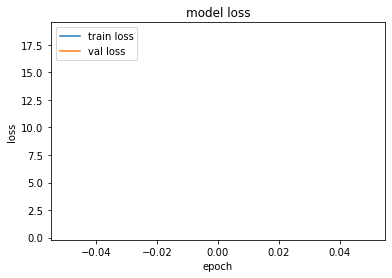

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

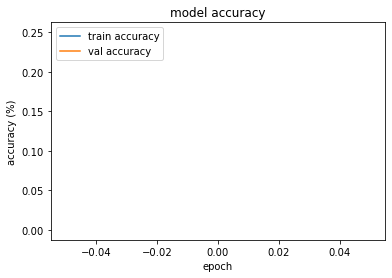

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

## Test model

In [ ]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set. 
def displayImage(index):
  img = X_dataset[index]
  
  img_aug = np.expand_dims(img, axis=0)
  y_predict = conv_model.predict(img_aug)[0]
  
  plt.imshow(img)  
  caption = ("                Dot | No Dots\n"+
             "GND truth: {:.2} | {:.2}\nPredicted: {:.2} | {:.2}".
             format(Y_dataset[index][0], Y_dataset[index][1], y_predict[0], y_predict[1]))
  plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')


interact(displayImage, 
        index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
                                   step=1, value=10))
#displayImage(3)

interactive(children=(IntSlider(value=10, description='index', max=10), Output()), _dom_classes=('widget-inter…

<function __main__.displayImage(index)>